# Brain Tumour Detection using MRI - Part 1

## Image Processing: Digital Assignment 1
## Done by Ritika Kayal, 18BCE2518


In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

from skimage.io import imread
from skimage.feature import greycomatrix, greycoprops
from sklearn import preprocessing
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

## Reading the Data

In [2]:
location = "../input/rawdata/input.jpg";
img = cv2.imread(location,1)
img.shape

(519, 456, 3)

In [3]:
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
original = img
original.shape
row, columns, channels = original.shape

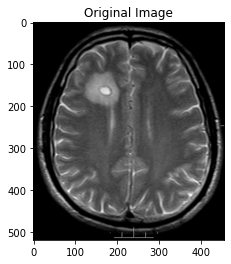

In [4]:
plt.imshow(original)
plt.title("Original Image")
plt.show()

## Image Enhancement and Restoration Techniques

## Color Conversion

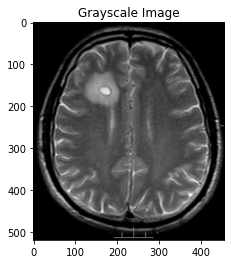

In [5]:
gray_img = cv2.cvtColor( original, cv2.COLOR_BGR2GRAY ) 
plt.imshow(gray_img,cmap='gray')
plt.title("Grayscale Image")
plt.show()

## Salt & Pepper Noise Removal

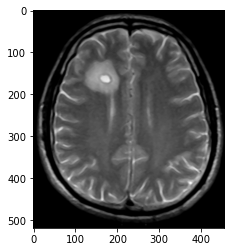

In [6]:
median_output = cv2.medianBlur(gray_img, 5)
plt.imshow(median_output,cmap='gray')
plt.show()

## Edge Detection using : 3*3 Sobel Filters


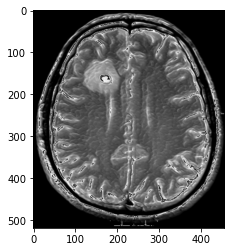

In [7]:
Gx= np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]])
Gy = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

sobelx = cv2.Sobel(median_output,cv2.CV_8U,1,0,ksize=3)
sobely = cv2.Sobel(median_output,cv2.CV_8U,0,1,ksize=3)

sobel_output = sobelx + sobely + gray_img
plt.imshow(sobel_output,cmap='gray')
plt.show()

## Thresholding

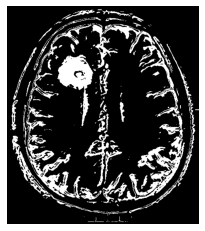

In [8]:
threshold = 127
maxValue = 255

th, threshold_filtered = cv2.threshold(sobel_output, threshold, maxValue, cv2.THRESH_BINARY)
plt.imshow(threshold_filtered,cmap='gray')
plt.axis('off')
plt.savefig("threshold_filtered.jpg")
plt.show()

# -------------------------------------------------------------------------------------------------------------

# Brain Tumour Detection using MRI - Part 2

## Image Processing: Digital Assignment 2
## Done by Ritika Kayal, 18BCE2518

# Input Image
## It is the output image obtained after the thresholding process

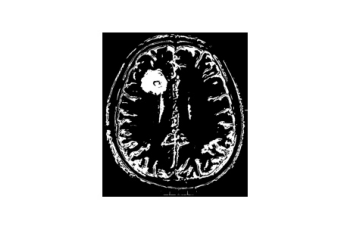

In [9]:
im = cv2.imread('./threshold_filtered.jpg')
plt.imshow(im, cmap="gray")
plt.axis('off')
plt.show()

## Morphological Processing 
### To remove any small white noises 

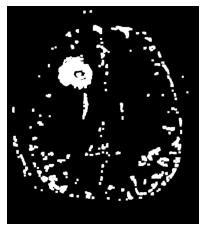

In [10]:
kernel = np.ones((3,3),np.uint8)
morph = cv2.morphologyEx(threshold_filtered,cv2.MORPH_OPEN,kernel, iterations = 2)

plt.imshow(morph,cmap='gray')
plt.axis('off')
plt.show()

## Black region removal
### To remove sure background area

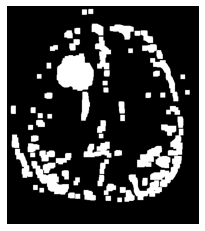

In [11]:
removed_bg = cv2.dilate(morph,kernel,iterations=3)

plt.imshow(removed_bg,cmap='gray')
plt.axis('off')
plt.show()

##  White region identification
### To identify sure foreground area

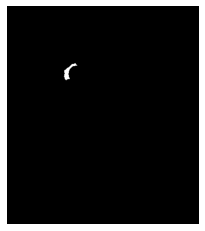

In [12]:
dist = cv2.distanceTransform(morph,cv2.DIST_L2,5)
ret, fg = cv2.threshold(dist,0.7*dist.max(),255,0)

plt.imshow(fg,cmap='gray')
plt.axis('off')
plt.show()

## Image Segmentation
### Identifying regions where we don't know whether foreground and background using Watershed algorithm

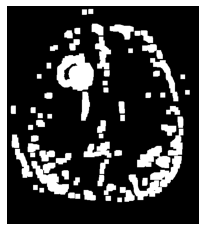

In [13]:
fg = np.uint8(fg)
unknown = cv2.subtract(removed_bg,fg)

plt.imshow(unknown,cmap='gray')
plt.axis('off')
plt.savefig("processed_img.png")
plt.show()

# This image is saved for feature extraction

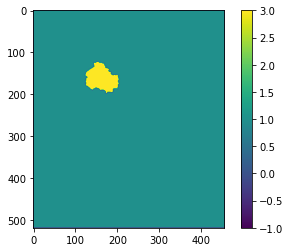

In [14]:
contours, _ = cv2.findContours(fg, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
marker = np.zeros((gray_img.shape[0], gray_img.shape[1]),dtype = np.int32)
marker = np.int32(fg) + np.int32(removed_bg)

# Marker Labelling
for id in range(len(contours)):
    cv2.drawContours(marker,contours,id,id+2, -1)

marker = marker + 1
marker[unknown==255] = 0
copy_img = original.copy()
cv2.watershed(copy_img, marker)
imgplt = plt.imshow(marker)
plt.colorbar()
plt.show()

# Detected Tumor

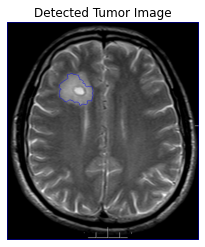

In [15]:
copy_img[marker==-1]=(0,0,255)
plt.imshow(copy_img,cmap='gray')
plt.axis('off')
plt.title('Detected Tumor Image')
plt.savefig("output_img.png")
plt.show()

# Feature Extraction of the Morphologically Processed Image
## These features can be used to train an ML model to classify detected tumors into various categories

### Reading the morphologically processed image

In [16]:
original=imread(os.path.join('./processed_img.png'))
img = cv2.cvtColor( original, cv2.COLOR_BGR2GRAY )

### Initialising the feature array

In [17]:
no_cols = 10
cols =np.asarray(['Contrast','Energy','Homogeneity','Correlation', 
                  'Dissimilarity','ASM','Area','Perimeter','Epsilon','IsConvex'])

no_samples = 1
features = np.ndarray((no_samples, no_cols))

### Performing feature extraction

In [18]:
ret,thresh = cv2.threshold(img,127,255,0)
contours,hierarchy = cv2.findContours(thresh, 1, 2)
c = contours[0]

area = cv2.contourArea(c)
perimeter = cv2.arcLength(c,True)
epsilon = 0.1*cv2.arcLength(c,True)
k = cv2.isContourConvex(c)
S = preprocessing.MinMaxScaler((0,11)).fit_transform(img).astype(int)
g = greycomatrix(S, distances=[1], angles=[0], levels=256, symmetric=False, normed=False)

contrast = greycoprops(g, 'contrast')
energy = greycoprops(g,'energy')
homogeneity = greycoprops(g, 'homogeneity')
correlation = greycoprops(g, 'correlation')
dissimilarity = greycoprops(g, 'dissimilarity')
ASM = greycoprops(g, 'ASM')

f_arr =  np.asarray([contrast[0][0],energy[0][0],homogeneity[0][0],correlation[0][0],dissimilarity[0][0],
                     ASM[0][0],area,perimeter,epsilon,k], dtype='object')
features[0] = f_arr

### Extracted features

In [19]:
df = pd.DataFrame(features, columns=cols)
df.head()

,Contrast,Energy,Homogeneity,Correlation,Dissimilarity,ASM,Area,Perimeter,Epsilon,IsConvex
0,1.043342,0.825128,0.969436,0.967901,0.161833,0.680836,12.0,14.0,1.4,1.0
